In [71]:
import cv2
import glob
import argparse
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power

def image_agcwd(img, a=0.25, truncated_cdf=False):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
    if truncated_cdf: 
        inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    else:
        inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
    return img_new

def process_bright(img):
    img_negative = 255 - img
    agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
    return agcwd

    
def adaptive_gamma_correction(img):    
    # Extract intensity component of the image
    YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = YCrCb[:,:,0]
    # Calculate histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])

    # Process image for gamma correction
    img_output = None
    if hist[:102].sum() > 0.3*hist.sum():
        print ("Underexposed Image")
        result = process_dimmed(Y)
        YCrCb[:,:,0] = result
        img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    elif hist[154:].sum() > 0.3*hist.sum():
        print ("Overexposed Image") # Bright Image
        result = process_bright(Y)
        YCrCb[:,:,0] = result
        img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    else:
        print ("Normal Image")
        img_output = img

    return img_output
    


In [36]:
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings

def anisodiff(img,niter=10,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	# really want
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else: 
			deltaSf=deltaS;
			deltaEf=deltaE;
			
		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

def anisotropic_diffusion_func(image):
    # Split the color image into its RGB channels
    alpha = 0.1  # Diffusion factor
    K = 30       # Perona-Malik coefficient
    niters = 10  # Number of iterations
    b, g, r = cv2.split(image)

    # Apply anisotropic diffusion to each channel
    b_filtered = anisodiff(b,kappa=50)
    g_filtered = anisodiff(g,kappa=50)
    r_filtered = anisodiff(r,kappa=50)

    # Merge the filtered channels back into a color image
    filtered_image = cv2.merge([b_filtered, g_filtered, r_filtered])
    filtered_image = filtered_image.astype(np.uint8)
    return filtered_image

In [1]:
import tensorflow as tf

def denoise(model, img):
    # Read the input image
#input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_img= img.astype(np.float32)/ 255.0
    # Process the image
    processed_img = _process_image(input_img, model)

    return processed_img

def _process_image(input_img, model):
    # Resize the input image
    image = tf.convert_to_tensor(input_img)
    
    # Handle multi-stage outputs, obtain the last scale output of the last stage
    preds = model.predict(tf.expand_dims(image, axis=0))
    if isinstance(preds,list):
        preds = preds[-1]
        if isinstance(preds,list):
            preds = preds[-1]
    preds = np.array(preds[0], np.float32)*255.0
    preds = (preds - np.min(preds))/(np.max(preds)- np.min(preds)) * 255
    preds = preds.astype(np.uint8)
    
    return preds

In [2]:
import cv2
import numpy as np
import eval_metrics
import matplotlib.pyplot as plt
import os

In [3]:
enhancement_model = tf.keras.models.load_model('D:/Pranav/Code/maxim-tf-main/models/Enhancement')
deblurring_model = tf.keras.models.load_model('D:/Pranav/Code/maxim-tf-main/models/Deblurring')
deraining_model = tf.keras.models.load_model('D:/Pranav/Code/maxim-tf-main/models/Deraining')
dehazing_model = tf.keras.models.load_model('D:/Pranav/Code/maxim-tf-main/models/Dehazing')
denoising_model = tf.keras.models.load_model('D:/Pranav/Code/maxim-tf-main/models/Denoising')

In [19]:
# Example usage:
import cv2
import os
img = cv2.imread('D:/Pranav/Data/CURE-TSD/input/Challenge-free/frames/frame_0243.png')
#img1 = cv2.imread('D:/Pranav/Data/CURE-TSD/input/Darkening-02/frames/frame_0135.png')
#img2 = cv2.imread('D:/Pranav/Data/CURE-TSD/input/Gaussian blur-02/frames/frame_0135.png')
#img3 = cv2.imread('D:/Pranav/Data/CURE-TSD/input/Rain-02/frames/frame_0135.png')
img4 = cv2.imread('D:/Pranav/Data/CURE-TSD/input/Haze-04/frames/frame_0243.png')
#img5 = cv2.imread('D:/Pranav/Data/CURE-TSD/input/Noise-02/frames/frame_0135.png')

SIZE = 256
#img4 = cv2.imread('D:/Pranav/Data/CURE-OR/input/underexposure-level4/01303.jpg')
img= cv2.resize(img, (SIZE, SIZE))
#img1 = cv2.resize(img1, (SIZE, SIZE))
#img2 = cv2.resize(img2, (SIZE, SIZE))
#img3 = cv2.resize(img3, (SIZE, SIZE))
img4 = cv2.resize(img4, (SIZE, SIZE))
#img5 = cv2.resize(img5, (SIZE, SIZE))

# Define the mean and standard deviation for the Gaussian noise
#y = denoise(enhancement_model, img1)
#y1 = denoise(deblurring_model, img2)
#y2 = denoise(deraining_model, img3)
y3 = denoise(dehazing_model, img4)
#y4 = denoise(denoising_model, img5)


1/1 [==============================] - 6s 6s/step


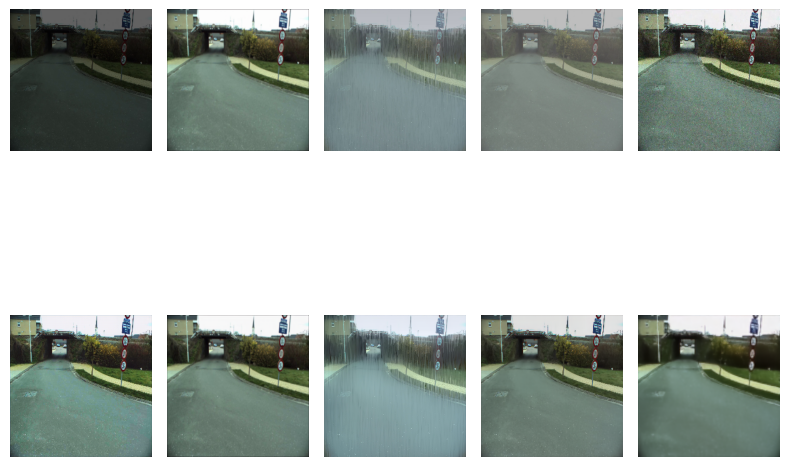

In [6]:
import matplotlib.pyplot as plt
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(2, 5, figsize=(8, 8))


#axes[0,3].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
#axes[0,3].axis('off')
# Display the first image on the left subplot
axes[0,0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0,0].axis('off')

axes[0,1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0,1].axis('off')

axes[0,2].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
axes[0,2].axis('off')

axes[0,3].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
axes[0,3].axis('off')

axes[0,4].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
axes[0,4].axis('off')

axes[1,0].imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))
axes[1,0].axis('off')

axes[1,1].imshow(cv2.cvtColor(y1, cv2.COLOR_BGR2RGB))
axes[1,1].axis('off')

axes[1,2].imshow(cv2.cvtColor(y2, cv2.COLOR_BGR2RGB))
axes[1,2].axis('off')

axes[1,3].imshow(cv2.cvtColor(y3, cv2.COLOR_BGR2RGB))
axes[1,3].axis('off')

axes[1,4].imshow(cv2.cvtColor(y4, cv2.COLOR_BGR2RGB))
axes[1,4].axis('off')


# Adjust layout to prevent clipping of titles
plt.tight_layout()
path = 'D:/Pranav/figures'
if not os.path.exists(path):
    os.makedirs(path)

plt.savefig(path+'/figure3.png', bbox_inches='tight')

# Show the plot
plt.show()

In [7]:
def PSNR(original, distorted, max_pixel=255.0):
    mse = np.mean((original - distorted) ** 2)
    if mse == 0:
        return float('inf')
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

In [12]:
import eval_metrics
psnr = eval_metrics.PSNR(img, img5)
ssim = eval_metrics.calculate_ssim(img, img5)
print(psnr)
print(ssim)
psnr = eval_metrics.PSNR(img, y4)
ssim = eval_metrics.calculate_ssim(img, y4)
print(psnr)
print(ssim)

29.688527243569837
0.6052710171649373
29.858462615432977
0.7034947642446996


In [14]:
from ultralytics import YOLO

In [74]:
sidd_img = cv2.imread('D:/Pranav/Data/CURE-OR/input/underexposure-level4/01208.jpg')
model = YOLO(r'D:\Pranav\Code\Object Detection\yolov8x.pt') 
result = model(sidd_img,save=True, conf=0.6) 


0: 640x448 1 bottle, 1645.6ms
Speed: 3.0ms preprocess, 1645.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs\detect\predict30


In [72]:
img = adaptive_gamma_correction(sidd_img)
result1 = model(img,save=True, conf=0.6) 

Underexposed Image

0: 640x448 1 bottle, 1797.2ms
Speed: 5.0ms preprocess, 1797.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs\detect\predict29


In [56]:
result=model(img,save=True, conf=0.2)


0: 640x640 2 persons, 1 tie, 1 chair, 2 couchs, 1 potted plant, 1 dining table, 1 vase, 3441.8ms
Speed: 10.0ms preprocess, 3441.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict24


In [73]:
result1[0].boxes.conf

tensor([0.9649])

In [70]:
result[0].boxes.conf

tensor([0.8730])

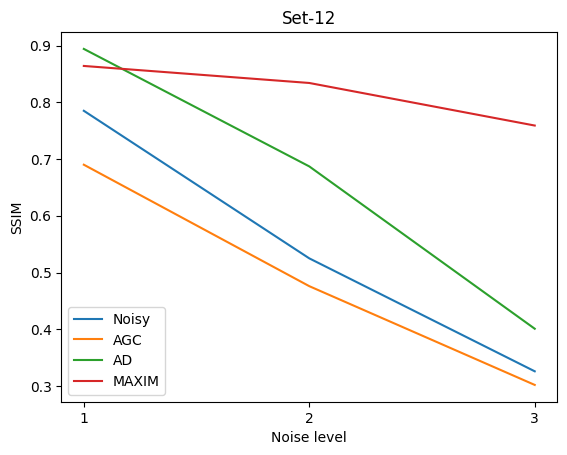

In [82]:
import matplotlib.pyplot as plt

# Your two 1x3 lists
list1 = [0.785, 0.525, 0.326]
list2 = [0.690, 0.476, 0.302]
list3 = [0.894, 0.687, 0.401]
list4 = [0.864, 0.834, 0.759]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the first list
ax.plot(list1, label='Noisy')

# Plot the second list
ax.plot(list2, label='AGC')
ax.plot(list3, label='AD')
ax.plot(list4, label='MAXIM')

ax.set_xticks(range(0,3))
ax.set_xticklabels(['1', '2', '3'])

# Add labels and legend
ax.set_xlabel('Noise level')
ax.set_ylabel('SSIM')
ax.legend()

ax.set_title('Set-12')

plt.savefig(path+'/figure4.png', bbox_inches='tight')

# Show the plot
plt.show()
